# Measurements Model

In this notebook, we develop a regression model for 14 distinct body metrics using BodyM dataset. These metrics serve as key indicators for estimating various aspects of body proportion. The list of 14 metrics is:

*   ankle
*   arm-length
*   bicep
*   calf
*   chest
*   forearm
*   height
*   hip
*   leg-length
*   shoulder-breadth
*   shoulder-to-crotch
*   thigh
*   waist
*   wrist

To accomplish this, we are using silhouette image, gender, height, and weight from the dataset as input and the 14 measurements as output of the model.

In this model we are utilizing MobileNetV3 as a feature extraction component. MobileNetV3 serves as a pre-trained convolutional neural network (CNN) known for its efficiency and accuracy in extracting meaningful features from images. This way we can get better prediction result from the silhouette image.

Resources:
* [BodyM Dataset](https://aws.amazon.com/marketplace/pp/prodview-w3762gcflmhzk?sr=0-1&ref_=beagle&applicationId=AWSMPContessa)
* [MobileNetV3Large](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large)
* [Single Fit Iteration](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Ftowardsdatascience.com%2Festimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import zipfile

import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Preprocess Dataset

In [ ]:
# Define the target file so we can extract all contents of the ZIP file
target_file = '.../train.zip'

extracting = zipfile.ZipFile(target_file, 'r')

extracting.extractall('')

extracting.close()

In [ ]:
# Read the gender, height, weight from hwg_metadata.csv
df_ghw = pd.read_csv('.../train/hwg_metadata.csv')

print(len(df_ghw))
df_ghw.head(3)

2018


,subject_id,gender,height_cm,weight_kg
0,AhfyGaD1BKo0-u6PeQk2oI-Bw5l0XxpAqNroFuZuy0I,female,160.00,92.4
1,E8tDQ5IgdBwbjLIXu7GwcupEHYbi0eB18YNcsgsSbP8,female,175.75,102.8
2,59bc2767681516389ccf45f9,male,174.80,106.9


In [ ]:
# Split df to make the order consistent
idx = 1
df_left = df_ghw.iloc[:, :idx+1]
df_right = df_ghw.iloc[:, idx+1:]
# One-hot encode the gender
df_left = pd.get_dummies(df_left, columns=['gender'])
# Combine them back
df_ghw_encoded = pd.concat([df_left, df_right], axis=1)

df_ghw_encoded.head(3)

,subject_id,gender_female,gender_male,height_cm,weight_kg
0,AhfyGaD1BKo0-u6PeQk2oI-Bw5l0XxpAqNroFuZuy0I,1,0,160.00,92.4
1,E8tDQ5IgdBwbjLIXu7GwcupEHYbi0eB18YNcsgsSbP8,1,0,175.75,102.8
2,59bc2767681516389ccf45f9,0,1,174.80,106.9


In [ ]:
# Read body measurements csv
df_measurements = pd.read_csv('.../train/measurements.csv')

print(len(df_measurements))
df_measurements.head(3)

2018


,subject_id,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist
0,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,24.343954,52.902378,33.294395,38.709511,102.526024,27.599094,177.610992,108.047134,81.736435,35.915691,67.891273,57.872795,92.286171,16.709131
1,-5OHO2b5mRDY1rvAf07sYYtekEEX7ViEGmvRr7l4tfc,22.001783,46.763233,28.288971,35.649963,99.253395,24.813375,164.379623,92.128685,75.127258,33.848778,60.541386,52.418320,87.307899,15.192038
2,-5iHTazqnmWBsnUY6ymoCw1kORMymRDaUla1eNOjgvI,26.565006,53.288597,30.800959,39.854950,102.391273,27.719795,183.718842,106.044121,84.055527,37.856457,72.004379,52.934086,96.596413,17.936598


In [ ]:
# Read the subject_id to photo_id map csv
df_subject_to_photo = pd.read_csv('.../train/subject_to_photo_map.csv')

print(len(df_subject_to_photo))
df_subject_to_photo.head(3)

6134


,subject_id,photo_id
0,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,e6f404ebda41ebe93573d3e219c88297
1,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,39a4241cb892618a694747e224d57b9e
2,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,a00a6c0c074efbd92c894cbc77023939


In [ ]:
# Combine photo_id, ghw, and measurements
df_combined = pd.merge(df_ghw_encoded, df_measurements, on='subject_id')
df_combined = pd.merge(df_subject_to_photo, df_combined, on='subject_id')

df_combined.head(3)

,subject_id,photo_id,gender_female,gender_male,height_cm,weight_kg,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist
0,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,e6f404ebda41ebe93573d3e219c88297,0,1,178.0,79.6,24.343954,52.902378,33.294395,38.709511,102.526024,27.599094,177.610992,108.047134,81.736435,35.915691,67.891273,57.872795,92.286171,16.709131
1,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,39a4241cb892618a694747e224d57b9e,0,1,178.0,79.6,24.343954,52.902378,33.294395,38.709511,102.526024,27.599094,177.610992,108.047134,81.736435,35.915691,67.891273,57.872795,92.286171,16.709131
2,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,a00a6c0c074efbd92c894cbc77023939,0,1,178.0,79.6,24.343954,52.902378,33.294395,38.709511,102.526024,27.599094,177.610992,108.047134,81.736435,35.915691,67.891273,57.872795,92.286171,16.709131


In [ ]:
# Make sure the distribution is normal and the count is all same
df_combined.describe()

,gender_female,gender_male,height_cm,weight_kg,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist
count,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000
mean,0.404956,0.595044,171.279842,76.167225,24.219577,49.587572,30.647770,37.515141,102.231733,26.617305,172.182688,103.144500,78.314696,35.853129,65.052293,54.367005,90.398772,16.708943
std,0.490924,0.490924,9.739855,17.778044,1.868445,3.244938,4.064022,3.255510,11.423383,2.717129,9.579463,10.067352,5.030899,2.715778,4.931898,5.559833,13.464555,1.469819
min,0.000000,0.000000,141.000000,28.700000,19.242346,39.386353,19.130898,28.268900,77.077766,18.881157,140.860458,80.676231,62.698711,28.627943,51.365982,37.689114,64.070488,13.093933
25%,0.000000,0.000000,164.100000,63.300000,22.847017,47.307637,27.914692,35.245613,94.270378,24.703722,165.049881,96.511545,74.877556,33.593109,61.173981,50.675931,80.614784,15.646706
50%,0.000000,1.000000,171.500000,74.100000,24.237638,49.705956,30.405067,37.261433,101.480789,26.626043,172.393623,101.575893,78.344353,36.225368,65.213867,53.679922,88.225235,16.683017
75%,1.000000,1.000000,178.375000,85.700000,25.481857,51.695949,32.860993,39.414600,108.485207,28.379400,179.081940,107.199402,81.552467,37.906567,68.668953,57.110142,98.315781,17.621370
max,1.000000,1.000000,197.200000,184.500000,32.977467,59.430515,55.813061,55.328609,153.940750,39.747761,197.510193,166.851578,94.486633,44.322525,79.315926,84.223358,164.296539,23.978992


In [ ]:
# Shuffle the DataFrame
df_combined_shuffled = shuffle(df_combined, random_state=123)

# Split the dataset into train, test, val
train_df, test_df = train_test_split(df_combined_shuffled, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=123)

In [ ]:
print(train_df.shape, test_df.shape, val_df.shape)

(4416, 20) (1227, 20) (491, 20)


## Create Data Generator to Load Dataset

The purpose of this data generator is to facilitate the loading and preprocessing of the dataset essential for training or evaluating the measurement model.



The "Custom Data Generator" class involves building a specialized function for managing the dataset. This generator is designed to efficiently load data in batches, perform necessary preprocessing such as resizing images, and prepare it for training or inference.

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, ghw_cols, label_cols, root_path, img_extension, batch_size, img_height, img_width):
        self.df = df
        self.ghw_cols = ghw_cols
        self.label_cols = label_cols
        self.root_path = root_path
        self.img_extension = img_extension
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size: (index + 1) * self.batch_size]

        images = []
        ghw_data = []
        measurements = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.root_path, row['photo_id'] + self.img_extension)

            if os.path.isfile(img_path):                            # if the file exist, proceed to load data
                image = self.load_image(img_path)
                images.append(image)
                ghw_data.append(row[self.ghw_cols].tolist())
                measurements.append(row[self.label_cols].tolist())

        return [np.array(images), np.array(ghw_data)], np.array(measurements)

    def load_image(self, path):
        # Load an image
        img = load_img(path)
        # Resize with padding so it's not deform the silhouette
        img = tf.image.resize_with_pad(img, target_height=self.img_height, target_width=self.img_width)
        # return the normalized image array
        return img_to_array(img) / 255.0

In [ ]:
root_path = ".../train/mask/"
img_extension = '.png'
IMG_HEIGHT = 512  # Desired height for image resizing
IMG_WIDTH = 512  # Desired width for image resizing
BATCH_SIZE = 64

ghw_columns = ['gender_female', 'gender_male', 'height_cm', 'weight_kg']
label_columns = ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']

# Create custom data generators for training, testing, and validation datasets
train_datgen = CustomDataGenerator(train_df, ghw_columns, label_columns, root_path, img_extension, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)
test_datgen = CustomDataGenerator(test_df, ghw_columns, label_columns, root_path, img_extension, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)
val_datgen = CustomDataGenerator(val_df, ghw_columns, label_columns, root_path, img_extension, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)

## Create model

Within the context of a measurements model aimed at predicting body metrics, the creation of the model involves utilizing MobileNet as a feature extraction component. MobileNet serves as a pre-trained convolutional neural network (CNN) known for its efficiency and accuracy in extracting meaningful features from images.


Resources:
https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large

### Load Pretrained MobileNetV3

In [ ]:
SILHOUETTE_IMG_DIM = (IMG_HEIGHT, IMG_WIDTH, 3)

measurement_base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=SILHOUETTE_IMG_DIM,
    include_top=False,
    weights="imagenet",
    pooling='avg',
    dropout_rate=0.5,
)

In [ ]:
measurement_base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 512, 512, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 256, 256, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 256, 256, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

### Build Model Architecture
Within the model architecture, we separate the input into image and GHW(gender, height, weight).
The image will first feed in to MobileNetV3 to extract important features before it goes to DNN. While the GHW are normalized first, then goes to DNN. To enable this architecture, we are using TF functional API.

In [ ]:
measurement_base_model.trainable = False

ghw_shape = (4,)      # [female, male, height, weight]
ghw_in = tf.keras.Input(shape=ghw_shape)
img_in = tf.keras.Input(shape=SILHOUETTE_IMG_DIM)

# Create (z-score) normalization and set its internal state using the training data
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(train_df[ghw_columns])

# Image feature extraction
img_out = measurement_base_model(img_in, training=False)  # set training to False because of BatchNormalization thing

# Deep Neural Network
ghw_normal = normalizer(ghw_in)                             # normalize before feed in to dense layer
x = tf.keras.layers.Concatenate()([ghw_normal, img_out])    # inject ghw_normal
x = tf.keras.layers.Dense(112, activation='relu')(x)
x = tf.keras.layers.Dense(28, activation='relu')(x)
outputs = tf.keras.layers.Dense(14, activation='linear')(x)
measurement_model = tf.keras.Model([img_in, ghw_in], outputs)

In [ ]:
measurement_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 normalization (Normalizati  (None, 4)                    9         ['input_2[0][0]']             
 on)                                                                                              
                                                                                                  
 MobilenetV3large (Function  (None, 960)                  2996352   ['input_3[0][0]']         

***
(Optional) You can add learning rate finder here, the code to run the learning rate finder is on the last cell.
***

## Train the Model

In [ ]:
measurement_model.compile(optimizer=tf.keras.optimizers.Adam(0.01450828),
                          loss=tf.keras.losses.MeanSquaredError(),
                          metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Define a ModelCheckpoint callback to save the best model
checkpoint_filepath = 'best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_root_mean_squared_error',
    mode='min',
    verbose=1
)

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2,
    monitor='val_root_mean_squared_error',
    mode='min',
    verbose=1
)

# Define ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=1,
    factor=0.6,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [ ]:
# Train the measurement model using the specified data generators

EPOCHS = 20

history = measurement_model.fit(
    train_datgen,
    epochs=EPOCHS,
    steps_per_epoch=len(train_datgen),
    validation_data=test_datgen,
    validation_steps=len(test_datgen),
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 762.6088 - mae: 15.1120 - root_mean_squared_error: 27.6154
Epoch 1: val_root_mean_squared_error improved from inf to 4.87696, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 160s 2s/step - loss: 762.6088 - mae: 15.1120 - root_mean_squared_error: 27.6154 - val_loss: 23.7847 - val_mae: 3.1741 - val_root_mean_squared_error: 4.8770 - lr: 0.0145
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 21.0767 - mae: 2.9302 - root_mean_squared_error: 4.5909
Epoch 2: val_root_mean_squared_error improved from 4.87696 to 4.48390, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 146s 2s/step - loss: 21.0767 - mae: 2.9302 - root_mean_squared_error: 4.5909 - val_loss: 20.1054 - val_mae: 2.8805 - val_root_mean_squared_error: 4.4839 - lr: 0.0145
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 18.9790 - mae: 2.7895 - root_mean_squared_error: 4.3565
Epoch 3: val_root_mean_squared_error improved from 4.48390 to 4.25887, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 146s 2s/step - loss: 18.9790 - mae: 2.7895 - root_mean_squared_error: 4.3565 - val_loss: 18.1380 - val_mae: 2.7343 - val_root_mean_squared_error: 4.2589 - lr: 0.0145
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 16.5481 - mae: 2.6484 - root_mean_squared_error: 4.0679
Epoch 4: val_root_mean_squared_error improved from 4.25887 to 3.85411, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 148s 2s/step - loss: 16.5481 - mae: 2.6484 - root_mean_squared_error: 4.0679 - val_loss: 14.8542 - val_mae: 2.5373 - val_root_mean_squared_error: 3.8541 - lr: 0.0145
Epoch 5/20
69/69 [==============================] - ETA: 0s - loss: 12.2419 - mae: 2.3575 - root_mean_squared_error: 3.4988
Epoch 5: val_root_mean_squared_error improved from 3.85411 to 3.10050, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 146s 2s/step - loss: 12.2419 - mae: 2.3575 - root_mean_squared_error: 3.4988 - val_loss: 9.6131 - val_mae: 2.1538 - val_root_mean_squared_error: 3.1005 - lr: 0.0145
Epoch 6/20
69/69 [==============================] - ETA: 0s - loss: 7.6359 - mae: 1.9298 - root_mean_squared_error: 2.7633
Epoch 6: val_root_mean_squared_error improved from 3.10050 to 2.55764, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 148s 2s/step - loss: 7.6359 - mae: 1.9298 - root_mean_squared_error: 2.7633 - val_loss: 6.5415 - val_mae: 1.8002 - val_root_mean_squared_error: 2.5576 - lr: 0.0145
Epoch 7/20
69/69 [==============================] - ETA: 0s - loss: 6.0474 - mae: 1.7309 - root_mean_squared_error: 2.4591
Epoch 7: val_root_mean_squared_error improved from 2.55764 to 2.40927, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 148s 2s/step - loss: 6.0474 - mae: 1.7309 - root_mean_squared_error: 2.4591 - val_loss: 5.8046 - val_mae: 1.6885 - val_root_mean_squared_error: 2.4093 - lr: 0.0145
Epoch 8/20
69/69 [==============================] - ETA: 0s - loss: 5.5504 - mae: 1.6603 - root_mean_squared_error: 2.3559
Epoch 8: val_root_mean_squared_error improved from 2.40927 to 2.33848, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 145s 2s/step - loss: 5.5504 - mae: 1.6603 - root_mean_squared_error: 2.3559 - val_loss: 5.4685 - val_mae: 1.6378 - val_root_mean_squared_error: 2.3385 - lr: 0.0145
Epoch 9/20
69/69 [==============================] - ETA: 0s - loss: 5.3583 - mae: 1.6265 - root_mean_squared_error: 2.3148
Epoch 9: val_root_mean_squared_error improved from 2.33848 to 2.33233, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 143s 2s/step - loss: 5.3583 - mae: 1.6265 - root_mean_squared_error: 2.3148 - val_loss: 5.4398 - val_mae: 1.6418 - val_root_mean_squared_error: 2.3323 - lr: 0.0145
Epoch 10/20
69/69 [==============================] - ETA: 0s - loss: 5.1653 - mae: 1.5961 - root_mean_squared_error: 2.2727
Epoch 10: val_root_mean_squared_error did not improve from 2.33233

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.008704967983067035.
69/69 [==============================] - 145s 2s/step - loss: 5.1653 - mae: 1.5961 - root_mean_squared_error: 2.2727 - val_loss: 5.4496 - val_mae: 1.6369 - val_root_mean_squared_error: 2.3344 - lr: 0.0145
Epoch 11/20
69/69 [==============================] - ETA: 0s - loss: 5.0073 - mae: 1.5676 - root_mean_squared_error: 2.2377
Epoch 11: val_root_mean_squared_error improved from 2.33233 to 2.27100, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 154s 2s/step - loss: 5.0073 - mae: 1.5676 - root_mean_squared_error: 2.2377 - val_loss: 5.1574 - val_mae: 1.5975 - val_root_mean_squared_error: 2.2710 - lr: 0.0087
Epoch 12/20
69/69 [==============================] - ETA: 0s - loss: 4.9261 - mae: 1.5500 - root_mean_squared_error: 2.2195
Epoch 12: val_root_mean_squared_error improved from 2.27100 to 2.25932, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 159s 2s/step - loss: 4.9261 - mae: 1.5500 - root_mean_squared_error: 2.2195 - val_loss: 5.1045 - val_mae: 1.5765 - val_root_mean_squared_error: 2.2593 - lr: 0.0087
Epoch 13/20
69/69 [==============================] - ETA: 0s - loss: 4.9215 - mae: 1.5504 - root_mean_squared_error: 2.2184
Epoch 13: val_root_mean_squared_error improved from 2.25932 to 2.24499, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 146s 2s/step - loss: 4.9215 - mae: 1.5504 - root_mean_squared_error: 2.2184 - val_loss: 5.0400 - val_mae: 1.5619 - val_root_mean_squared_error: 2.2450 - lr: 0.0087
Epoch 14/20
69/69 [==============================] - ETA: 0s - loss: 4.8502 - mae: 1.5375 - root_mean_squared_error: 2.2023
Epoch 14: val_root_mean_squared_error did not improve from 2.24499

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.005222980678081512.
69/69 [==============================] - 147s 2s/step - loss: 4.8502 - mae: 1.5375 - root_mean_squared_error: 2.2023 - val_loss: 5.2579 - val_mae: 1.6001 - val_root_mean_squared_error: 2.2930 - lr: 0.0087
Epoch 15/20
69/69 [==============================] - ETA: 0s - loss: 4.8026 - mae: 1.5288 - root_mean_squared_error: 2.1915
Epoch 15: val_root_mean_squared_error improved from 2.24499 to 2.22503, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 164s 2s/step - loss: 4.8026 - mae: 1.5288 - root_mean_squared_error: 2.1915 - val_loss: 4.9507 - val_mae: 1.5510 - val_root_mean_squared_error: 2.2250 - lr: 0.0052
Epoch 16/20
69/69 [==============================] - ETA: 0s - loss: 4.7215 - mae: 1.5158 - root_mean_squared_error: 2.1729
Epoch 16: val_root_mean_squared_error improved from 2.22503 to 2.21262, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 152s 2s/step - loss: 4.7215 - mae: 1.5158 - root_mean_squared_error: 2.1729 - val_loss: 4.8957 - val_mae: 1.5465 - val_root_mean_squared_error: 2.2126 - lr: 0.0052
Epoch 17/20
69/69 [==============================] - ETA: 0s - loss: 4.7156 - mae: 1.5155 - root_mean_squared_error: 2.1715
Epoch 17: val_root_mean_squared_error improved from 2.21262 to 2.20585, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 147s 2s/step - loss: 4.7156 - mae: 1.5155 - root_mean_squared_error: 2.1715 - val_loss: 4.8658 - val_mae: 1.5360 - val_root_mean_squared_error: 2.2059 - lr: 0.0052
Epoch 18/20
69/69 [==============================] - ETA: 0s - loss: 4.7133 - mae: 1.5162 - root_mean_squared_error: 2.1710
Epoch 18: val_root_mean_squared_error did not improve from 2.20585

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0031337885186076163.
69/69 [==============================] - 147s 2s/step - loss: 4.7133 - mae: 1.5162 - root_mean_squared_error: 2.1710 - val_loss: 5.0759 - val_mae: 1.5738 - val_root_mean_squared_error: 2.2530 - lr: 0.0052
Epoch 19/20
69/69 [==============================] - ETA: 0s - loss: 4.6568 - mae: 1.5067 - root_mean_squared_error: 2.1580
Epoch 19: val_root_mean_squared_error improved from 2.20585 to 2.19754, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 151s 2s/step - loss: 4.6568 - mae: 1.5067 - root_mean_squared_error: 2.1580 - val_loss: 4.8292 - val_mae: 1.5335 - val_root_mean_squared_error: 2.1975 - lr: 0.0031
Epoch 20/20
69/69 [==============================] - ETA: 0s - loss: 4.6236 - mae: 1.5000 - root_mean_squared_error: 2.1503
Epoch 20: val_root_mean_squared_error did not improve from 2.19754

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0018802730832248925.
69/69 [==============================] - 150s 2s/step - loss: 4.6236 - mae: 1.5000 - root_mean_squared_error: 2.1503 - val_loss: 4.8529 - val_mae: 1.5355 - val_root_mean_squared_error: 2.2029 - lr: 0.0031


In [ ]:
measurement_model.save('best_measurement_model.h5')

In [ ]:
# Continue training with the latest learning rate

measurement_model.compile(optimizer=tf.keras.optimizers.Adam(0.0018802730832248925),
                          loss=tf.keras.losses.MeanSquaredError(),
                          metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

EPOCHS = 20

measurement_model2 = tf.keras.models.load_model('best_measurement_model.h5')
history2 = measurement_model2.fit(
    train_datgen,
    epochs=EPOCHS,
    steps_per_epoch=len(train_datgen),
    validation_data=test_datgen,
    validation_steps=len(test_datgen),
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 4.6072 - mae: 1.4964 - root_mean_squared_error: 2.1464
Epoch 1: val_root_mean_squared_error improved from 2.19754 to 2.19399, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 151s 2s/step - loss: 4.6072 - mae: 1.4964 - root_mean_squared_error: 2.1464 - val_loss: 4.8136 - val_mae: 1.5284 - val_root_mean_squared_error: 2.1940 - lr: 0.0019
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 4.5977 - mae: 1.4960 - root_mean_squared_error: 2.1442
Epoch 2: val_root_mean_squared_error improved from 2.19399 to 2.18995, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 147s 2s/step - loss: 4.5977 - mae: 1.4960 - root_mean_squared_error: 2.1442 - val_loss: 4.7959 - val_mae: 1.5270 - val_root_mean_squared_error: 2.1900 - lr: 0.0019
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 4.5727 - mae: 1.4911 - root_mean_squared_error: 2.1384
Epoch 3: val_root_mean_squared_error did not improve from 2.18995

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001128163863904774.
69/69 [==============================] - 144s 2s/step - loss: 4.5727 - mae: 1.4911 - root_mean_squared_error: 2.1384 - val_loss: 4.8152 - val_mae: 1.5309 - val_root_mean_squared_error: 2.1944 - lr: 0.0019
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 4.5656 - mae: 1.4904 - root_mean_squared_error: 2.1367
Epoch 4: val_root_mean_squared_error improved from 2.18995 to 2.18681, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 145s 2s/step - loss: 4.5656 - mae: 1.4904 - root_mean_squared_error: 2.1367 - val_loss: 4.7821 - val_mae: 1.5251 - val_root_mean_squared_error: 2.1868 - lr: 0.0011
Epoch 5/20
69/69 [==============================] - ETA: 0s - loss: 4.5538 - mae: 1.4885 - root_mean_squared_error: 2.1340
Epoch 5: val_root_mean_squared_error did not improve from 2.18681

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006768983323127031.
69/69 [==============================] - 146s 2s/step - loss: 4.5538 - mae: 1.4885 - root_mean_squared_error: 2.1340 - val_loss: 4.7852 - val_mae: 1.5276 - val_root_mean_squared_error: 2.1875 - lr: 0.0011
Epoch 6/20
69/69 [==============================] - ETA: 0s - loss: 4.5533 - mae: 1.4892 - root_mean_squared_error: 2.1338
Epoch 6: val_root_mean_squared_error improved from 2.18681 to 2.18266, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 146s 2s/step - loss: 4.5533 - mae: 1.4892 - root_mean_squared_error: 2.1338 - val_loss: 4.7640 - val_mae: 1.5217 - val_root_mean_squared_error: 2.1827 - lr: 6.7690e-04
Epoch 7/20
69/69 [==============================] - ETA: 0s - loss: 4.5468 - mae: 1.4874 - root_mean_squared_error: 2.1323
Epoch 7: val_root_mean_squared_error did not improve from 2.18266

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0004061390063725412.
69/69 [==============================] - 143s 2s/step - loss: 4.5468 - mae: 1.4874 - root_mean_squared_error: 2.1323 - val_loss: 4.7682 - val_mae: 1.5213 - val_root_mean_squared_error: 2.1836 - lr: 6.7690e-04
Epoch 8/20
69/69 [==============================] - ETA: 0s - loss: 4.5402 - mae: 1.4862 - root_mean_squared_error: 2.1308
Epoch 8: val_root_mean_squared_error improved from 2.18266 to 2.17898, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 145s 2s/step - loss: 4.5402 - mae: 1.4862 - root_mean_squared_error: 2.1308 - val_loss: 4.7480 - val_mae: 1.5190 - val_root_mean_squared_error: 2.1790 - lr: 4.0614e-04
Epoch 9/20
69/69 [==============================] - ETA: 0s - loss: 4.5331 - mae: 1.4850 - root_mean_squared_error: 2.1291
Epoch 9: val_root_mean_squared_error did not improve from 2.17898

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002436834038235247.
69/69 [==============================] - 159s 2s/step - loss: 4.5331 - mae: 1.4850 - root_mean_squared_error: 2.1291 - val_loss: 4.7621 - val_mae: 1.5205 - val_root_mean_squared_error: 2.1822 - lr: 4.0614e-04
Epoch 10/20
69/69 [==============================] - ETA: 0s - loss: 4.5319 - mae: 1.4848 - root_mean_squared_error: 2.1288
Epoch 10: val_root_mean_squared_error improved from 2.17898 to 2.17803, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 145s 2s/step - loss: 4.5319 - mae: 1.4848 - root_mean_squared_error: 2.1288 - val_loss: 4.7438 - val_mae: 1.5191 - val_root_mean_squared_error: 2.1780 - lr: 2.4368e-04
Epoch 11/20
69/69 [==============================] - ETA: 0s - loss: 4.5288 - mae: 1.4844 - root_mean_squared_error: 2.1281
Epoch 11: val_root_mean_squared_error improved from 2.17803 to 2.17766, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 144s 2s/step - loss: 4.5288 - mae: 1.4844 - root_mean_squared_error: 2.1281 - val_loss: 4.7422 - val_mae: 1.5180 - val_root_mean_squared_error: 2.1777 - lr: 2.4368e-04
Epoch 12/20
69/69 [==============================] - ETA: 0s - loss: 4.5266 - mae: 1.4841 - root_mean_squared_error: 2.1276
Epoch 12: val_root_mean_squared_error improved from 2.17766 to 2.17701, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 141s 2s/step - loss: 4.5266 - mae: 1.4841 - root_mean_squared_error: 2.1276 - val_loss: 4.7394 - val_mae: 1.5167 - val_root_mean_squared_error: 2.1770 - lr: 2.4368e-04
Epoch 13/20
69/69 [==============================] - ETA: 0s - loss: 4.5242 - mae: 1.4836 - root_mean_squared_error: 2.1270
Epoch 13: val_root_mean_squared_error improved from 2.17701 to 2.17691, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 143s 2s/step - loss: 4.5242 - mae: 1.4836 - root_mean_squared_error: 2.1270 - val_loss: 4.7389 - val_mae: 1.5170 - val_root_mean_squared_error: 2.1769 - lr: 2.4368e-04
Epoch 14/20
69/69 [==============================] - ETA: 0s - loss: 4.5246 - mae: 1.4840 - root_mean_squared_error: 2.1271
Epoch 14: val_root_mean_squared_error improved from 2.17691 to 2.17616, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 141s 2s/step - loss: 4.5246 - mae: 1.4840 - root_mean_squared_error: 2.1271 - val_loss: 4.7357 - val_mae: 1.5156 - val_root_mean_squared_error: 2.1762 - lr: 2.4368e-04
Epoch 15/20
69/69 [==============================] - ETA: 0s - loss: 4.5248 - mae: 1.4840 - root_mean_squared_error: 2.1272
Epoch 15: val_root_mean_squared_error improved from 2.17616 to 2.17613, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 140s 2s/step - loss: 4.5248 - mae: 1.4840 - root_mean_squared_error: 2.1272 - val_loss: 4.7355 - val_mae: 1.5164 - val_root_mean_squared_error: 2.1761 - lr: 2.4368e-04
Epoch 16/20
69/69 [==============================] - ETA: 0s - loss: 4.5230 - mae: 1.4837 - root_mean_squared_error: 2.1267
Epoch 16: val_root_mean_squared_error did not improve from 2.17613

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00014621004229411482.
69/69 [==============================] - 152s 2s/step - loss: 4.5230 - mae: 1.4837 - root_mean_squared_error: 2.1267 - val_loss: 4.7403 - val_mae: 1.5182 - val_root_mean_squared_error: 2.1772 - lr: 2.4368e-04
Epoch 17/20
69/69 [==============================] - ETA: 0s - loss: 4.5190 - mae: 1.4829 - root_mean_squared_error: 2.1258
Epoch 17: val_root_mean_squared_error improved from 2.17613 to 2.17516, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 140s 2s/step - loss: 4.5190 - mae: 1.4829 - root_mean_squared_error: 2.1258 - val_loss: 4.7313 - val_mae: 1.5155 - val_root_mean_squared_error: 2.1752 - lr: 1.4621e-04
Epoch 18/20
69/69 [==============================] - ETA: 0s - loss: 4.5184 - mae: 1.4828 - root_mean_squared_error: 2.1257
Epoch 18: val_root_mean_squared_error did not improve from 2.17516

Epoch 18: ReduceLROnPlateau reducing learning rate to 8.772602886892855e-05.
69/69 [==============================] - 141s 2s/step - loss: 4.5184 - mae: 1.4828 - root_mean_squared_error: 2.1257 - val_loss: 4.7340 - val_mae: 1.5160 - val_root_mean_squared_error: 2.1758 - lr: 1.4621e-04
Epoch 19/20
69/69 [==============================] - ETA: 0s - loss: 4.5147 - mae: 1.4818 - root_mean_squared_error: 2.1248
Epoch 19: val_root_mean_squared_error did not improve from 2.17516

Epoch 19: ReduceLROnPlateau reducing learning rate to 5.2635619067586954e-05.
69/69 [==============================] - 14

In [ ]:
measurement_model2.save('best_measurement_model (1).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Extend previous history with new history
# No need to extend if the cell for continuing training (with 'history 2' variable) is not executed
history.history['loss'].extend(history2.history['loss'])
history.history['mae'].extend(history2.history['mae'])
history.history['root_mean_squared_error'].extend(history2.history['root_mean_squared_error'])
history.history['val_loss'].extend(history2.history['val_loss'])
history.history['val_mae'].extend(history2.history['val_mae'])
history.history['val_root_mean_squared_error'].extend(history2.history['val_root_mean_squared_error'])

## Visualize Training

Visualizing training involves creating graphical representations (such as plots) that depict various metrics tracked during the training process. These metrics include Model Loss, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation RMSE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Root Mean Squared Error (RMSE)')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

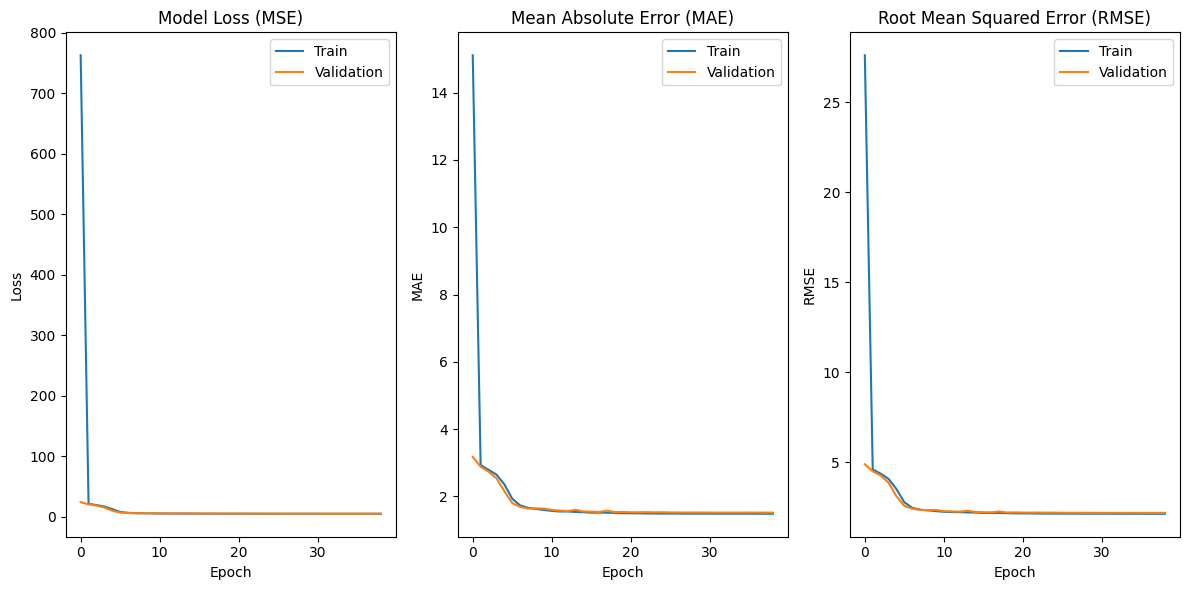

In [ ]:
# Call the function to plot training history
plot_training_history(history)

## Validate the Model

Validating the model involves assessing its performance and generalization capabilities on unseen or validation data. This phase is crucial to ensure the model's reliability in predicting or analyzing body measurements accurately.

In [ ]:
test_load = tf.keras.models.load_model('best_model.h5')

# Make predictions with data that wasn't used for model optimization
predictions = test_load.predict(val_datgen, verbose=1)
test_load.evaluate(val_datgen)

7/7 [==============================] - 13s 2s/step - loss: 4.7144 - mae: 1.4838 - root_mean_squared_error: 2.1713


[4.7143754959106445, 1.4838365316390991, 2.1712613105773926]

In [ ]:
# Create DataFrames for predictions and ground truth
predictions_df = pd.DataFrame(predictions, columns=label_columns)
ground_truth_df = pd.DataFrame(val_datgen[0][1], columns=label_columns)

In [ ]:
# Make sure there's no anomaly with the result generated by the model
predictions_df.head()

,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist
0,24.531105,48.925869,31.697601,38.265488,105.944168,27.924376,171.388870,103.369675,77.065796,37.410923,66.574600,54.112606,94.431870,17.371296
1,26.441992,56.037930,32.299641,39.034286,107.340408,28.581345,190.462677,106.731010,87.466179,38.575115,72.420036,56.555416,95.336052,17.485147
2,23.614197,47.653904,31.154818,37.917194,103.087891,25.602978,166.012466,107.940132,75.780472,33.981701,61.361980,57.147194,92.330154,16.242254
3,23.434374,47.182549,29.281746,36.334953,98.669205,26.441006,166.040527,96.381737,74.696251,36.127808,64.089478,50.322598,86.267693,16.730682
4,25.799566,53.005657,32.398232,38.923931,108.314888,28.621815,182.559708,106.223694,83.001587,38.201748,70.271149,55.994305,96.645615,17.634157


In [ ]:
ground_truth_df.head()

,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist
0,25.262775,47.964298,31.071802,43.240440,104.506744,27.278835,171.472366,101.403427,74.816277,37.494717,66.015083,54.918598,89.621651,16.138348
1,25.368204,58.893646,28.940063,38.321571,108.637756,26.564302,191.502502,108.701042,90.315147,40.292061,71.589996,53.441792,102.331245,17.196285
2,24.241146,48.738064,30.151600,39.314144,109.509407,24.779694,168.869095,111.251251,78.277374,33.736912,61.608250,56.124268,99.254410,15.876008
3,22.717184,47.252445,31.561316,34.992542,97.359032,27.284473,166.293411,95.681946,73.794312,34.984818,64.956497,52.962936,83.928856,16.427145
4,25.281464,55.267673,30.063631,37.543396,107.558800,26.974592,185.096085,109.728416,85.346893,37.237804,70.330544,55.959278,100.912277,17.869257


# Learning Rate Finder

The learning rate finder is a technique to discover a suitable learning rate for your model. This code snippet demonstrates how we use a learning rate finder to be used in our model.

## Parameters

- **lr_df_size:** The size of the subset of the training data used for the learning rate finder. Increasing it provides a better representation of the loss but may take longer to run.

- **lr_epochs:** The number of epochs for the learning rate finder. Increasing it improves resolution but may extend the runtime.

- **min_lr:** The minimum learning rate to explore. Reducing it helps to check lower learning rates.

- **max_lr:** The maximum learning rate to explore. It's set a bit high, but you can adjust the result by trimming it based on the output.

In [ ]:
# Parameters
lr_df_size = 2      # increase for better loss representation (reduce if it takes a long time to run)(recommended: 10 maybe)
lr_epochs = 100     # increase for better resolution (reduce if it takes a long time to run)(recommended: 50-100)
min_lr = 1e-2       # reduce to check lower learning rate (1e-2 = 0.01)
max_lr = 1          # it's a bit too far but you can trim the result

# Create a small subset of the data for learning rate finder
lr_df = train_df.iloc[:lr_df_size]
lr_datgen = CustomDataGenerator(lr_df, ghw_columns, label_columns, root_path, img_extension, lr_df_size, IMG_HEIGHT, IMG_WIDTH)

# Create the test model (identical with the actual model)
lr_model = tf.keras.Model([img_in, ghw_in], outputs)
# Store the initial weights
lr_init_weight = lr_model.get_weights()

## Estimating Optimal Learning Rate for Fast Model Convergence

For further insights and background information, refer to the original source: [Estimating Optimal Learning Rate for a Deep Neural Network](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0).

In [ ]:
# Create a scheduler
def lr_schedule(epoch):
    # The learning rate grow exponentially every epoch
    return min_lr * (max_lr / min_lr) ** (epoch / (lr_epochs - 1))
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Reset weight
lr_model.set_weights(lr_init_weight)

# Compile the test model
lr_model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.MeanSquaredError(),
                 metrics=["mae"])

# Train the test model
lr_history = lr_model.fit(lr_datgen,
                          epochs=lr_epochs,
                          steps_per_epoch=len(lr_datgen),
                          callbacks=[lr_scheduler])

# After the learning rate finder, set the model weights back to the initial state
lr_model.set_weights(lr_init_weight)

In [ ]:
# Plot the loss for every LR
plt.semilogx(lr_history.history['lr'], lr_history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Calculate the derivative of the loss with respect to iteration number
# to find the best learning rate with the fastest decrease in the loss
# slope = loss[curr] - loss[prev]

derivative = []
for i in range(1, lr_epochs):
    prev_loss = lr_history.history['loss'][i-1]
    curr_loss = lr_history.history['loss'][i]
    derivative.append(curr_loss - prev_loss)

# Visualize the derivative
plt.plot(range(1, lr_epochs), derivative, marker='o')
# plt.axis([80, 100, -2000, 3000])      # uncomment this to see the index where it start become unstable ([min x, max x, min y, max y])
plt.xlabel('Iteration Number')
plt.ylabel('d(Loss)')
plt.show()

In [ ]:
# Trim the part where the graph started to become unstable
derivative = derivative[:87]

min_dL_idx = np.argmin(derivative)                  # get the index of the minimum value
dL_val = derivative[min_dL_idx]
best_lr = lr_history.history['lr'][min_dL_idx]
print("Best learning rate: " + str(best_lr))
print("Epoch num         : " + str(min_dL_idx+1))
print("Loss reduced      : " + str(dL_val))

## Other Method to Find Optimal Learning Rate

Since the previous method using a single training, each learning rate that being evaluated are not taking the same starting loss. In our opinion, that method might not fairly judge each learning rate performance. Hence, we develop this other method.

In [ ]:
# Parameter
lr_epoch_depth = 2  # 2 is minimum

lr = min_lr * (max_lr / min_lr) ** (np.arange(lr_epochs) / (lr_epochs - 1))
# Iterate over learning rates and train the model with each rate
res = []
for i in lr:
    # Set the model weights to the initial state
    lr_model.set_weights(lr_init_weight)
    print("lr: " + str(i))

    # Compile the model with the current learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=i)
    lr_model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # Train the model for a few epochs (you can adjust the number of epochs)
    temp_history = lr_model.fit(lr_datgen, epochs=lr_epoch_depth, steps_per_epoch=len(lr_datgen))

    # save the loss from the last epoch
    res.append(temp_history.history['loss'][lr_epoch_depth-1])

# After the learning rate finder, set the model weights back to the initial state
lr_model.set_weights(lr_init_weight)

In [ ]:
import matplotlib.pyplot as plt

# Plot learning rates against losses
plt.semilogx(lr, res, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

In [ ]:
min_res_idx = np.argmin(res)                  # get the index of the minimum value
res_val = res[min_res_idx]
best_lr = lr_history.history['lr'][min_res_idx]
print("Best learning rate: " + str(best_lr))
print("Iter num          : " + str(min_res_idx))
print("Loss reduced to   : " + str(res_val))